# **给 Colab 用户的重要提示**

# **切勿在此文件中直接书写——你的修改可能会丢失！**

# **开始前请务必先另存一份副本。**

如何另存副本

1. 点击左上角的“File”。
> *如果看不到菜单栏（例如“File”或“Runtime”），点击右上角的“v”箭头显示它。*

2. 选择“Save a copy in Drive”。

3. 把复制后的文件名改成“YOURNAMEs_FileName.ipynb”。
> 例如：你叫 Olivia，改成 Olivias_FileName.ipynb



---

* 选中的对勾（✅）不会被保存。用 Chrome 的刷新按钮刷新网页，对勾会消失。<br>
如果想暂停后续再做，可以新建一个文本单元，写“SO FAR DONE”之类的标记。

---

* Colab 中，**之前的输出结果每隔 30 到 90 分钟就会重置**。<br>
  因此，`~~ is not defined` 这类错误会非常频繁地发生。

  🔁 出现 `~~ is not defined` 错误怎么办
  1. 先检查变量名拼写有没有错。<br>
  2. 如果拼写没问题但仍报错，**点击需要重新运行的那个代码单元**。<br>
  3. 点击左上角的“Runtime”→选“Run before”。<br>
    → 这会**重新按顺序运行之前所有单元**。
  4. 再次运行该单元。

  如果上述操作后仍有错误，<br>
  可能是你之前单元中的 TODO 答案有根本问题。<br>
  请认真检查答案是否正确。<br>
  或者找 ChatGPT 或其他编程助手帮忙。

# **Preparation**

本节仅加载前面章节的内容。<br>
直接运行代码即可，无需阅读。<br>
可以直接跳过。<br>

In [ ]:
# 下载文件
!wget https://raw.githubusercontent.com/HayatoHongo/Everyones_nanoGPT/main/input.txt -O input.txt
# 加载刚下载的名为 input.text 的文件，编码为 utf-8。
with open("input.txt", 'r', encoding = 'utf-8') as f:
    text = f.read()

# 一个用于美观显示张量的函数（可跳过）
import torch
import torch.nn as nn
import torch.nn.functional as F

def print_formatted_tensor(*args, width=6, decimals=2):
    """
    A function that neatly formats and displays a PyTorch Tensor, and also prints its size.

    Example usage:
        print_formatted_tensor("name", tensor)
        print_formatted_tensor(tensor)

    Args:
        *args: If given 1 argument, it is treated as a tensor.
               If given 2 arguments, the first is treated as the name, the second as the tensor.
        width (int): Display width for each number (default: 6)
        decimals (int): Number of decimal places to show (default: 2)
    """

    # Determine tensor and name from arguments
    if not args:
        raise ValueError("At least one argument is required.")
    if isinstance(args[0], str):
        if len(args) < 2:
            raise ValueError("Tensor is not specified.")
        name, tensor = args[0], args[1]
    else:
        name, tensor = None, args[0]

    # Convert Tensor to List
    tensor_list = tensor.detach().cpu().tolist()

    def format_list(lst, indent):
        """Formatting a recursively nested list and returning a string"""
        # If the contents are lists, then re-return
        if isinstance(lst, list) and lst and isinstance(lst[0], list):
            inner = ",\n".join(" " * indent + format_list(sub, indent + 2) for sub in lst)
            return "[\n" + inner + "\n" + " " * (indent - 2) + "]"
        # For numerical lists
        return "[" + ", ".join(f"{v:{width}.{decimals}f}" for v in lst) + "]"

    # Formatted string (bar brackets on outermost frames are removed)
    formatted = format_list(tensor_list, indent=9)
    inner_formatted = formatted[1:-1].strip()

    # Result output
    if name:
        print(name)
    print(f"Tensor Size: {list(tensor.size())}")
    print("tensor([")
    print(" " * 9 + inner_formatted)
    print(" " * 7 + "])")

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        # 定义一个嵌入表，用于词汇量为 x，嵌入维度为 number 的情况
        self.token_embedding_table = nn.Embedding(vocab_size, embedding_dim)

    def embed(self, input_indices):
        # 获取对应输入索引的嵌入向量
        return self.token_embedding_table.forward(input_indices)

# 定义位置嵌入模块
class PositionEmbedding(nn.Module):
    def __init__(self, input_sequence_length, embedding_dim):
        super().__init__()
        # 位置嵌入层
        self.position_embedding_layer = nn.Embedding(input_sequence_length, embedding_dim)

    def forward(self, input_indices):
        sequence_length = input_indices.shape[1]  # 获取序列长度
        position_indices = torch.arange(sequence_length, device=input_indices.device)  # 位置索引生成
        position_embeddings = self.position_embedding_layer(position_indices)  # 位置嵌入
        return position_embeddings

class EmbeddingModule(nn.Module):
    def __init__(self, vocab_size, config):
        super().__init__()
        # 为每个标记嵌入的层
        self.token_embedding_layer = TokenEmbedding(vocab_size = vocab_size, embedding_dim = config.embedding_dim)
        self.position_embedding_layer = PositionEmbedding(input_sequence_length = config.input_sequence_length, embedding_dim = config.embedding_dim)

    def forward(self, input_indices):
        # 获取 token 嵌入
        token_embeddings = self.token_embedding_layer.embed(input_indices)

        # 获取位置嵌入
        position_embeddings = self.position_embedding_layer.forward(input_indices)

        # 添加词元嵌入和位置嵌入
        embeddings = token_embeddings + position_embeddings
        return embeddings

class AttentionHead(nn.Module):
    def __init__(self, head_size, config):
        super().__init__()
        self.key_fc= nn.Linear(config.embedding_dim, head_size, bias=False)
        self.query_fc = nn.Linear(config.embedding_dim, head_size, bias=False)
        self.value_fc = nn.Linear(config.embedding_dim, head_size, bias=False)

        # 掩码通过下三角矩阵创建（保持自注意力的因果性）
        self.register_buffer('tril', torch.tril(torch.ones(config.input_sequence_length, config.input_sequence_length)))

        # 丢弃法
        self.dropout = DeterministicDropout(config.dropout_rate)
        self.head_size = head_size

    def forward(self, input_tensor):
        B, T, C = input_tensor.shape  # 批次，令牌长度，嵌入通道

        key = self.key_fc.forward(input_tensor)     # (B, T, head_size)
        query = self.query_fc.forward(input_tensor)   # （B，T，head_size）
        value = self.value_fc.forward(input_tensor)   # (B, T, head_size)

        # 计算注意力分数 (QK^T) * self.head_size **(-0.5)
        attention_scores = query @ key.transpose(-2, -1) * self.head_size**(-0.5)

        # 已应用掩码
        attention_scores = attention_scores.masked_fill(self.tril[:T, :T] == 0, float('-inf'))

        # Softmax → Dropout → 加权和
        attention_weights = F.softmax(attention_scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        out = attention_weights @ value  # （B，T，head_size）
        return out

class DeterministicDropout(nn.Module):
    def __init__(self, p=0.1, seed=199):
        super().__init__()
        self.p = p
        # 创建一个固定的随机数生成器
        self.generator = torch.Generator()
        self.generator.manual_seed(seed)

    def forward(self, x):
        if self.training:
            # 使用固定生成器生成随机数
            mask = (torch.rand(x.shape, generator=self.generator, device=x.device, dtype=x.dtype) > self.p)
            return x * mask / (1 - self.p)
        else:
            return x

class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.num_attention_heads = config.num_attention_heads
        self.embedding_dim = config.embedding_dim

        # 头尺寸是嵌入维度数除以注意力头数。在此示例中，8/2 = 4 即为 self.head_size。
        self.head_size = int(self.embedding_dim / self.num_attention_heads)

        # 使用 ModuleList 管理多个头部
        self.attention_heads = nn.ModuleList([
            AttentionHead(self.head_size, config)
            for _ in range(self.num_attention_heads)
        ])

        # 用于混合每个头输出的线性层
        self.output_projection = nn.Linear(self.embedding_dim, self.embedding_dim)

        # 输出的丢弃率
        self.dropout = DeterministicDropout(config.dropout_rate)

    def forward(self, input_tensor):
        # 获取每个头的输出
        head_outputs_list = [head(input_tensor) for head in self.attention_heads]  # (B, T, head_dim) 的列表

        # 将所有头的输出连接起来 → (B, T, embedding_dim)
        concatenated = torch.cat(head_outputs_list, dim=-1)

        # 将输出与线性变换混合
        projected = self.output_projection(concatenated)

        # 对最终输出应用dropout
        output = self.dropout(projected)

        return output

class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.fc1 = nn.Linear(config.embedding_dim, config.hidden_dim)  # 第一层
        self.relu = nn.ReLU()  # 激活函数
        self.fc2 = nn.Linear(config.hidden_dim, config.embedding_dim)  # 第二层全连接层
        self.dropout = DeterministicDropout(config.dropout_rate) # 丢弃法

    def forward(self, attention_output_tensor):
        hidden_tensor = self.fc1(attention_output_tensor)

        activated_tensor = self.relu(hidden_tensor)

        output_tensor = self.fc2(activated_tensor)

        final_output_tensor = self.dropout(output_tensor)

        return final_output_tensor

class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(config.embedding_dim)
        self.layer_norm2 = nn.LayerNorm(config.embedding_dim)

        self.multihead_attention = MultiHeadAttention(config=config)
        self.feed_forward = FeedForward(config=config)

    def forward(self, input_tensor):
        normed_input = self.layer_norm1(input_tensor) # 对输入应用层归一化
        attention_output = self.multihead_attention(normed_input) # 对归一化输入应用多头注意力
        residual_attention = input_tensor + attention_output # 残差连接（将注意力的输出加到原始输入上（归一化之前））
        normed_attention = self.layer_norm2(residual_attention) # 再次对残差输出应用LayerNorm
        feedforward_output = self.feed_forward(normed_attention) # 应用前馈网络 (FFN)
        final_output = residual_attention + feedforward_output # 残差连接（将 FFN 的输出加到之前的残差输出上（归一化前））

        return final_output

class VocabularyLogits(nn.Module):
    def __init__(self, vocab_size, config):
        super().__init__()
        self.output_norm = nn.LayerNorm(config.embedding_dim)  # 层归一化
        self.vocab_projection = nn.Linear(config.embedding_dim, vocab_size)  # 词汇量投影

    def forward(self, transformer_blocks_output):
        # 对 Transformer 模块的输出应用层归一化
        normalized_output = self.output_norm(transformer_blocks_output)  # （批量大小，序列长度，嵌入维度）

        # 线性转换到词汇表大小以计算每个字符的得分
        vocab_logits = self.vocab_projection(normalized_output)  # （批量大小，序列长度，词汇表大小）

        return vocab_logits

# 配置类，存储模型设置
class ModelConfig:
    batch_size = 1  # 每次处理的数据量（批次大小）
    input_sequence_length = 8  # 输入数据长度（序列长度）
    embedding_dim = 8  # 嵌入层大小（特征向量的维度数）
    hidden_dim = 16 # 前馈层中的隐藏层大小
    num_attention_heads = 2  # 注释机制头编号
    dropout_rate = 0.1  # 丢弃概率

# 我刚把目前的流程整理了一下，这样我就可以跳过它了
torch.manual_seed(1337)

# 创建 ModelConfig 实例。无配置参数（构造函数）。
config = ModelConfig()

# 正在创建 EmbeddingModule 实例。
embedding_module = EmbeddingModule(vocab_size = 65, config = config)

# 创建一个 Transformer 块实例。
transformer_block1 = TransformerBlock(config=config)
transformer_block2 = TransformerBlock(config=config)

# 兼容 Let's he。（批量大小，令牌长度）=（1，8）
sample_input_tokens = torch.tensor([[24, 43, 58, 5, 57, 1, 46, 43]])
sample_embeddings = embedding_module.forward(sample_input_tokens)

# 通过第一个 Transformer 块
transformer_block1_output = transformer_block1.forward(sample_embeddings)
transformer_block2_output = transformer_block2.forward(transformer_block1_output)
print_formatted_tensor("transformer_block2输出", transformer_block2_output)

# **Chapter 11: Bigram Language Model**

让我们把到目前为止的所有步骤都整理一下，创建完整的 BigramLanguageModel 类。<br>

### **Section 1: The __init__ Method**

🔘 **Options**：可能会有一些你用不上的额外选项。

`TokenEmbedding`  `PositionEmbedding`  `EmbeddingModule`  `TransformerBlock`  `VocabularyLogits`

In [ ]:
class BigramLanguageModel(nn.Module):
    def __init__(self, config, vocab_size):
        super().__init__()
        # 定义嵌入式模块
        self.embedding = _____________(vocab_size=vocab_size, config=config)

        # 定义一个仅由 config.layer_counts 个 TransformerBlocks 堆叠而成的模块
        self.blocks = nn.Sequential(
            *[______________(config=config)
              for _ in range(config.layer_count)]
        )

        # 词汇量投影
        self.vocab_projection = ______________(vocab_size=vocab_size, config=config)


<details>
<summary>点击这里显示/隐藏答案</summary>

```python
class BigramLanguageModel(nn.Module):
    def __init__(self, config, vocab_size):
        super().__init__()
        self.embedding = EmbeddingModule(vocab_size=vocab_size, config=config)

        # 定义一个模块，堆叠了 config.layer_count 个 TransformerBlock
        self.blocks = nn.Sequential(
            *[TransformerBlock(config=config)
              for _ in range(config.layer_count)]
        )

        # 映射到词汇表大小的投影层
        self.vocab_projection = VocabularyLogits(vocab_size=vocab_size, config=config)
```

**Chapter 11: BigramLanguageModel: Section 1: init Method** <label><input type="checkbox"> 标记为完成</label>

### **Section 2: The forward Method**

输入是一串句子 ID。输出给出每个单词的概率以及正确答案与概率之间的损失。<br>
在深度学习模型类中，forward 方法通常不仅返回训练时的预测概率（前向传播），还返回正确答案与概率之间的损失。

🔘 **Options**：可能会有一些你用不到的额外选项。

`self.embedding`　`self.blocks`　`self.vocab_projection`　`input_indices`　`embeddings`　`vocab_size`　`batch_size`　`token_len`　`vocab_size`　`nn.MSELoss()`　`nn.CrossEntropyLoss()`　`nn.BCELoss()`

In [ ]:
# BigramLanguageModel 类定义
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size, config):
        super().__init__()
        self.embedding = EmbeddingModule(vocab_size, config=config)
        self.blocks = nn.Sequential(*[TransformerBlock(config=config) for _ in range(config.layer_count)])
        self.vocab_projection = VocabularyLogits(config.embedding_dim, vocab_size)
        self.criterion = nn.CrossEntropyLoss()

    # 计算损失
    def forward(self, input_indices, target_indices):
      # 嵌入式（方法 forward 是可选的）
      embeddings = _____________(__________)
      # 传递变换器块（方法 forward 可选）
      blocks_output = _________(_________)
      # 输出词汇表logit（方法`forward`为可选）
      vocab_logits = __________(blocks_output)

      # 推理时没有正确的索引，因此无法计算损失。返回 vocab_logits 作为可能性，损失返回 None。
      if target_indices is None:
        return vocab_logits, None

      # 损失计算
      batch_size, token_len, vocab_size = vocab_logits.shape
      vocab_logits = vocab_logits.view(_________ * __________, _________) # 重塑为二维以使用 nn.CrossEntropyLoss 实例
      targets = target_indices.view(_________ * __________) # 重塑为一维以使用 nn.CrossEntropyLoss 实例
      criterion = __________________
      # 输出词汇表的logit（方法`forward`为可选）
      loss = self.criterion(vocab_logits, targets)

      return vocab_logits, loss

<details>
<summary>点击此处显示/隐藏答案</summary>

```python
# BigramLanguageModel 类定义
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size, config):
        super().__init__()
        self.embedding = EmbeddingModule(vocab_size, config=config)
        self.blocks = nn.Sequential(*[TransformerBlock(config=config) for _ in range(config.layer_count)])
        self.vocab_projection = VocabularyLogits(config.embedding_dim, vocab_size)
        self.criterion = nn.CrossEntropyLoss()

    # 计算损失
    def forward(self, input_indices, target_indices):
      # 嵌入（方法 `forward` 可选）
      embeddings = self.embedding(input_indices)
      # 通过 Transformer block（方法 `forward` 可选）
      blocks_output = self.blocks(embeddings)
      # 输出词表 logits（方法 `forward` 可选）
      vocab_logits = self.vocab_projection(blocks_output)

      # 推理时没有正确的索引，无法计算损失，返回 vocab_logits 作为概率，损失返回 None。
      if target_indices is None:
        return vocab_logits, None

      # 计算损失
      batch_size, token_len, vocab_size = vocab_logits.shape
      vocab_logits = vocab_logits.view(batch_size * token_len, vocab_size)  # 重塑为二维以使用 nn.CrossEntropyLoss
      targets = target_indices.view(batch_size * token_len)  # 重塑为一维以使用 nn.CrossEntropyLoss
      # 输出词表 logits（方法 `forward` 可选）
      loss = self.criterion(vocab_logits, targets)

      return vocab_logits, loss
```

**Chapter 11: BigramLanguageModel: Section 2 forward Method** <label><input type="checkbox"> Mark as Done</label>

### **Section 3: The generate Method**

在 [ChatGPT](https://chatgpt.com/) 输入“Explain deep learning”，查看回答。<br>
然后，再次输入同样的提示。<br>
虽然问的是同一个问题，回答却会有些许不同。<br>
你可能会说，“这不明显吗？”<br>
但你知道为什么吗？<br>
本节将探讨这些差异产生的原因。跟着我们一起看看！

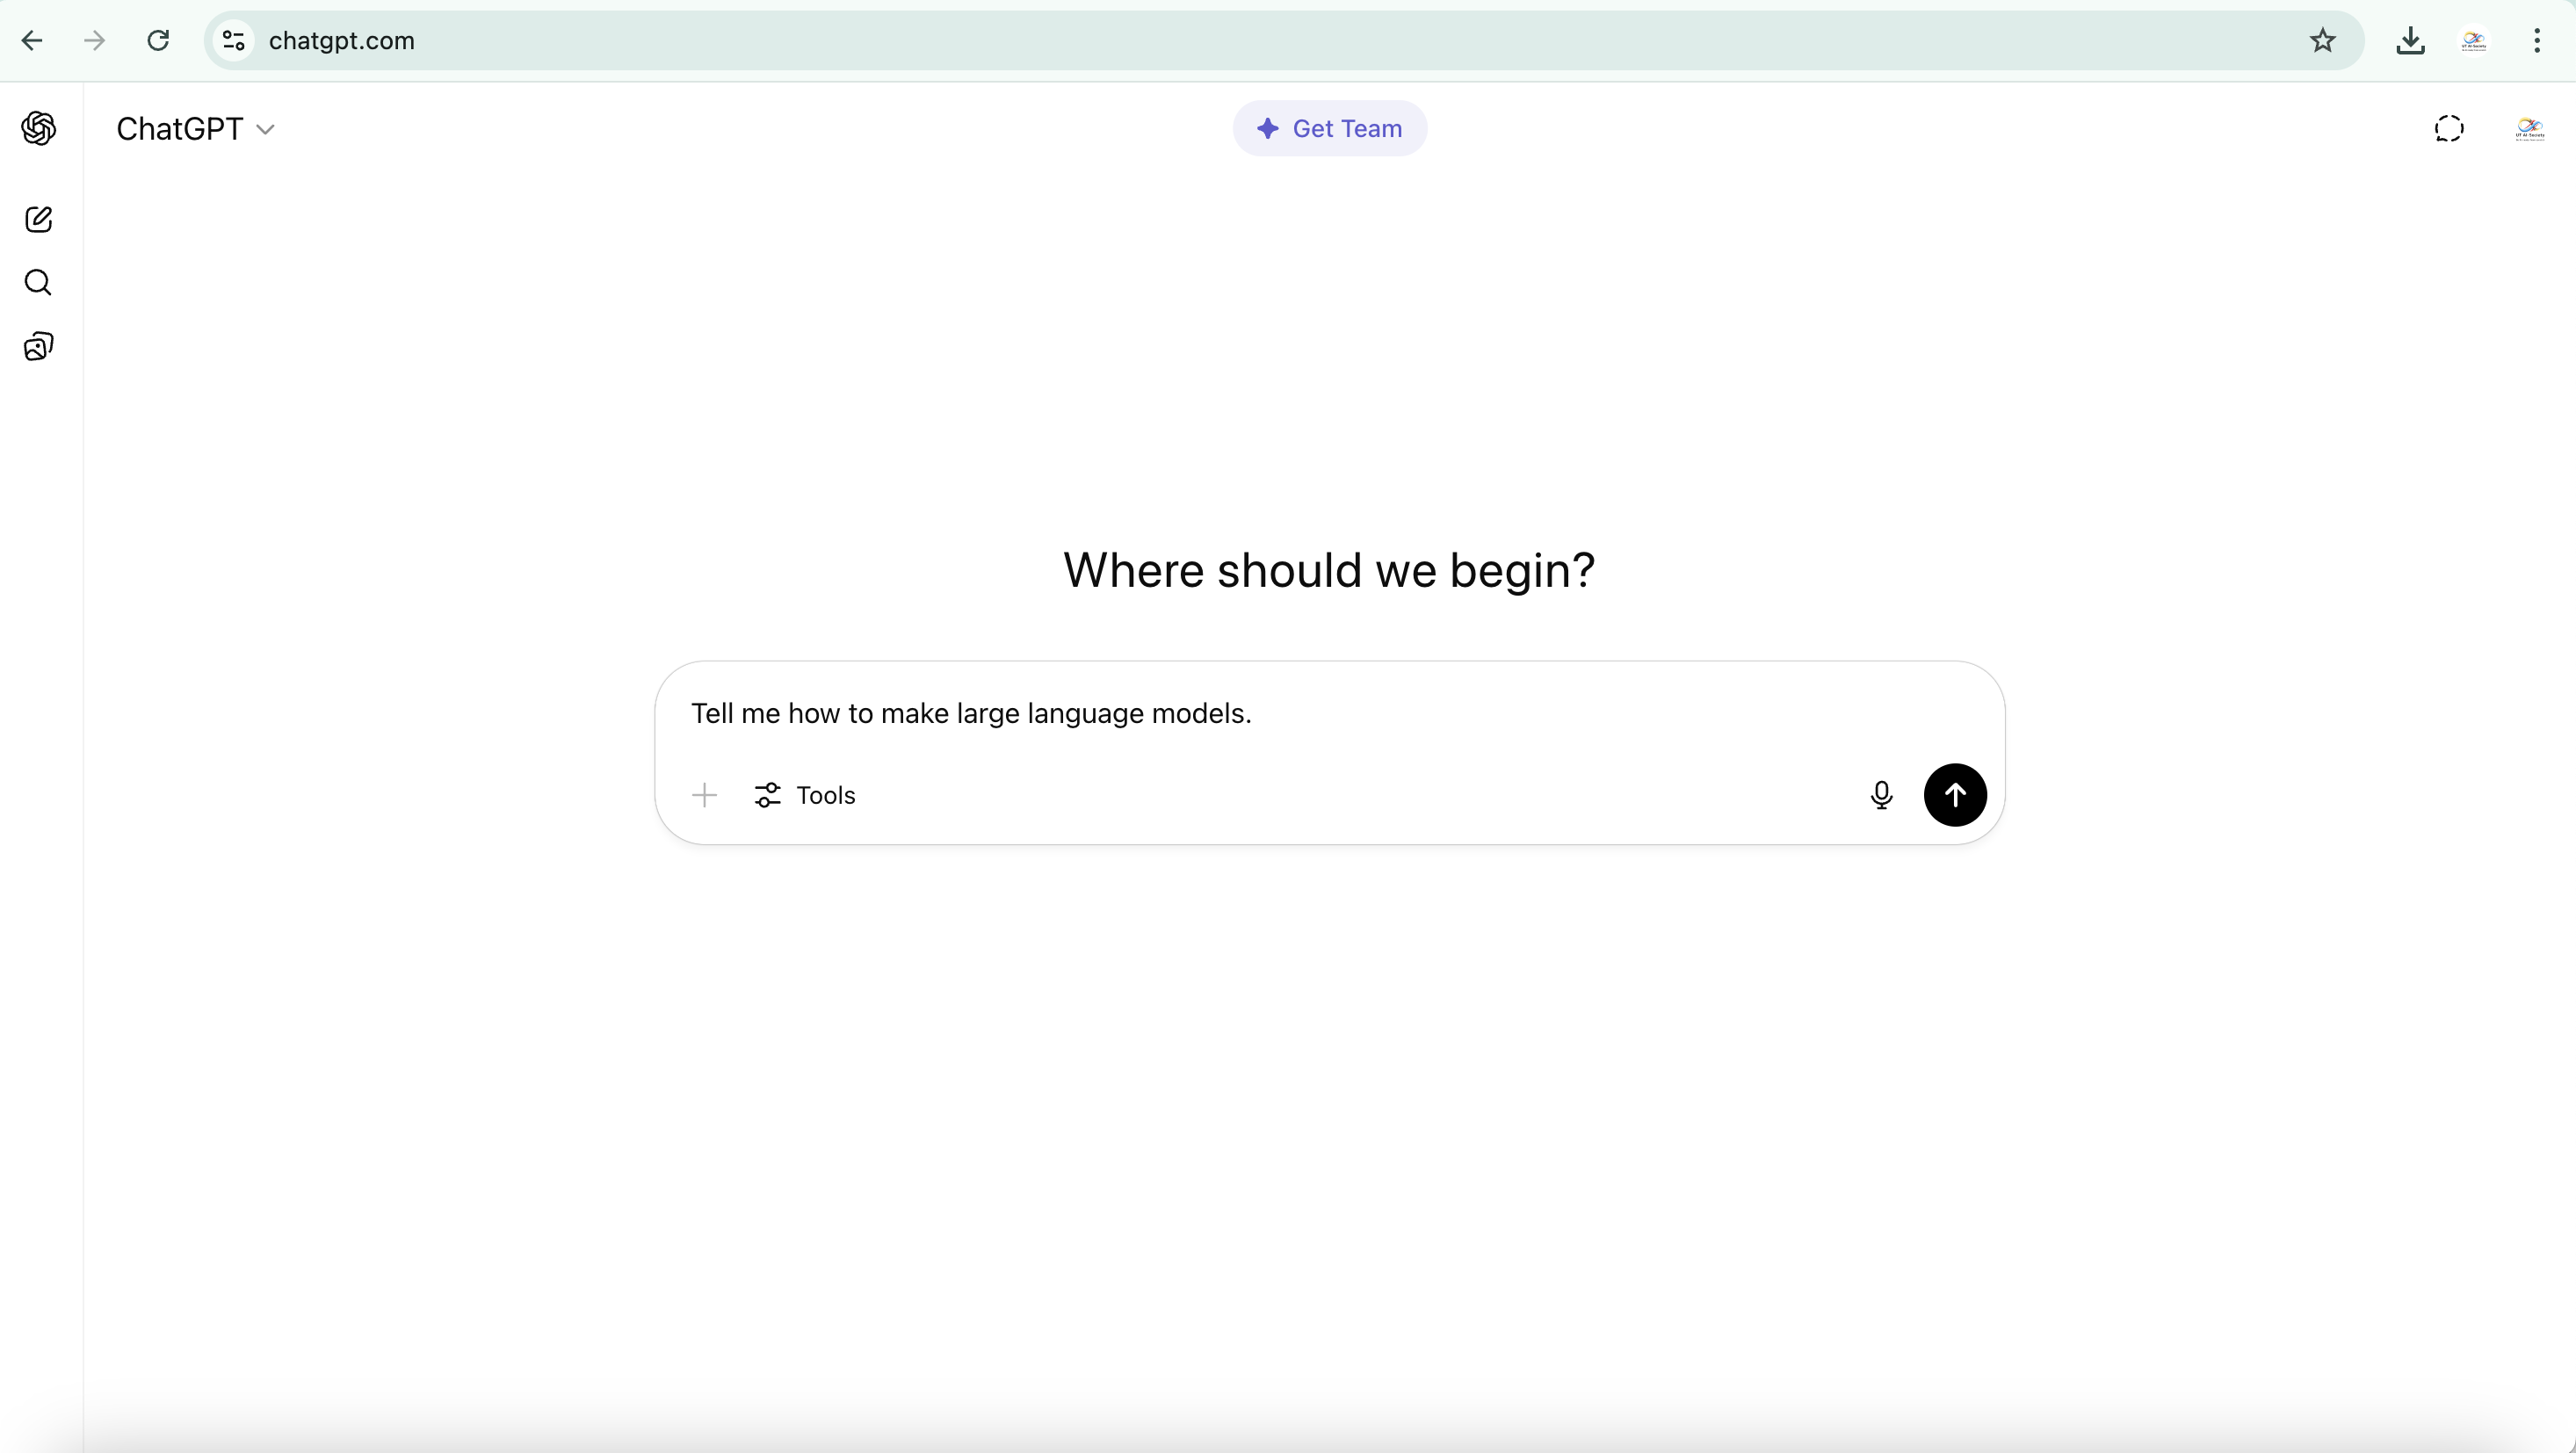

**模型如何推断词语**

本节讲解如何用语言模型来猜词。  
首先用一个简单例子来说明基本思路。  
<br>
<br>
🎯 **目标**

比如，我们考虑从下面的输入（prompt）生成输出。  
- **输入（prompt）**：`I`  
- **输出**：`I love you`

通常，`BigramLanguageModel` 类把字符当作 token。  
但这里为了简单起见，改用**词作为 token**。  
<br>
<br>
🧠 **关键点：模型预测每个位置的“下一个 token”，不仅仅是一个**

这个语言模型会预测**输入序列中每个位置的下一个词（token）**。  
<br>
<br>
**步骤 1**  
- **输入**：`["I"]`  
- 模型输出：预测的 tokens → `["love"]`  
  - 预测出 “love” 是 “I” 后面跟的词  
- 把最后预测的 “love” 加为新的 token  
- **结果**：`["I", "love"]`  
<br>
<br>

**步骤 2**  
- **输入**：`["I", "love"]`  
- 模型输出：预测的 tokens → `["love", "you"]`  
  - 预测 “love” 后面跟 “you”  
- 加入最后预测的 “you”  
- **结果**：`["I", "love", "you"]`  
<br>
<br>
---

这样，模型**一次性预测输入序列中每个位置的下一个 token**。  
然后在生成文本时，**只用最后一个位置的预测结果挑选下一个 token**。  
这就是运作的关键。

In [ ]:
import torch
import torch.nn.functional as F

#### **贪心采样**

- 词汇表（在这个简单示例中，6个单词）：`["I", "you", "am", "is", "love", "hate"]`

In [ ]:
vocab = {"I": 0, "you": 1, "am": 2, "is": 3, "love": 4, "hate": 5}

- 初始输入：`[[0]]`（=“我”）。（批量大小，令牌长度）=（1，1）

In [ ]:
input_indices = torch.tensor([[0]])  # 我

- 假设模型输出的 logits 如下。形状为 (B, T, V) = (1, 1, 6)

In [ ]:
logits = torch.tensor([[[1.0, 0.5, 0.0, -1.0, 3.0, 2.0]]])  # 对应的词语顺序是：["我", "你", "是", "是", "爱", "恨"]
print("logits 形状", logits.shape)

获取最后一个token的词汇表得分

In [ ]:
# 获取最后一个标记的词汇得分
# 输出张量大小: (B, V) =  (1, 6)
last_logits = logits[:,-1,:]
print_formatted_tensor("最后的logits", last_logits)

用 Softmax 转换为概率

In [ ]:
probs = # TODO: F.softmax(THINK_FOR_YOURSELF, dim=最后一个维度)
print_formatted_tensor("概率", probs)

贪心采样（始终选择概率最高的token）

```python
Function: torch.argmax  
Args:  
  - probs: 概率分布张量，形状为 (B, V)  
  - dim=-1: 沿最后一维选最大值的索引  
  - keepdim=True: 保持该维度，方便后续拼接  
Assign to: next_token
```

* `torch.argmax` 返回最大值的索引。
* 设定 `dim=-1` 就是选词表维度中概率最高的词。
* `keepdim=True` 保留那一维，以便后续操作（比如拼接）。
* `next_token` 就是这一步最可能的词的索引。
* 例子里，“love”出现了，因为它的概率最高。


In [ ]:
next_token = # TODO: 函数(参数)
print("next_token", next_token)  # 爱

**`Check Point`** <label><input type="checkbox">next_token tensor([[4]])</label>

```python
Function: torch.cat
Arguments: (input_indices, next_token), dim=THINK_FOR_YOURSELF
Assign to: input_indices
```

* `torch.cat` 会沿指定维度拼接张量。
* 请沿列方向（token轴）拼接。
* 它把 `input_indices`（第一个“I”）和 `next_token`（“love”）连接起来。
* 结果是令牌序列：“I”，“love”。

In [ ]:
input_indices = torch.tensor([[0]])  # 我
input_indices = # TODO: 函数(参数)
print("input_indices", input_indices)  # 我 爱

**`Check Point`** <label><input type="checkbox">input_indices tensor([[0, 4]])</label>

---


**Step 2: 输入 "I love"**


In [ ]:
input_indices = torch.tensor([[0, 4]])  # 我爱

- 假设模型输出的 logits 是这样。<br>
（输入长度为 2 → 模型输出长度也为 2。重点关注最后一个 token。）

In [ ]:
logits = torch.tensor([[[1.0, 0.5, 0.0, -1.0, 3.0, 2.0],  # 跳过（“I”的输出）
                        [0.5, 3.2, -1.0, 0.0, 0.2, -0.5]]])  # 查看此内容（“love”的输出）

In [ ]:
# 获取最后一个标记的词汇分数
last_logits = logits[:,-1,:]
print_formatted_tensor("最后的logits", last_logits)

用 Softmax 转换为概率

In [ ]:
probs = F.softmax(last_logits, dim=-1)
print_formatted_tensor("概率", probs)

贪心采样（总是选择概率最高的token）

In [ ]:
next_token = # TODO: 使用 torch.argmax
print("next_token", next_token)  # 你

**`Check Point`** <label><input type="checkbox">next_token tensor([[1]])</label>

In [ ]:
input_indices = torch.tensor([[0, 4]])  # 我 爱
input_indices = torch.cat((input_indices, next_token), dim=-1)
print("input_indices", input_indices)  # 我 爱 你

**`Check Point`** <label><input type="checkbox">input_indices 张量([[0, 4, 1]])</label>

另一方面，**Max sampling**（总是选取概率最高的词）容易导致**重复**，比如：

> *I am a large language model, I am a large language model, ...*

这个问题通过使用多项式采样（Multinomial sampling）可以得到**缓解**。

#### **多项式采样**

多项式采样根据概率来挑选词语。

比如，假设有这么个概率分布：

```
[ 0.08,  0.05,  0.03,  0.01,  0.60,  0.22 ]
```

这里，

- Token 0（比如“I”）有8%的概率，
- Token 1（比如“you”）有5%的概率，
- Token 2（比如“am”）有3%的概率，
- Token 3（比如“is”）有1%的概率，
- Token 4（比如“love”）有60%的概率，
- Token 5（比如“hate”）有22%的概率。

每个词被选中的机会就是这么定的。

多项式采样中，模型**随机根据这个分布挑一个词**。

概率高的词（比如“love”）会更常被选中。

概率低的词（比如“is”）则很少被选到。

这样，模型在构造句子时，就能**有概率地选出“更可能”的词**。

```python
函数：torch.multinomial  
参数：  
  - probs：词概率分布的张量  
  - num_samples=1：抽取一个样本  
赋值给：next_token
````

* `torch.multinomial` 从分类分布中随机采样。  
* 它根据 `probs` 选择一个词索引。  
* 与 `torch.argmax` 不同，它为生成加入了随机性。  
* `num_samples=1` 每个批次取一个索引，赋给 `next_token`。

In [ ]:
torch.manual_seed(1337)

probs = torch.tensor([[0.08, 0.05, 0.03, 0.01, 0.60, 0.22]])
next_token = # TODO: 函数(参数)
print("next_token", next_token)  # 讨厌

选用“hate”这个词是因为**Multinomial sampling**能生成自然且多样的输出结果。


**Step 2: 输入“I hate”**

In [ ]:
input_indices = torch.tensor([[0, 5]])  # 我讨厌

模型输出：logits（长度为2 → 模型输出长度也为2。关注最后一个token）

In [ ]:
# 假设获得了以下模型输出的logits
logits = torch.tensor([[[1.0, 0.5, 0.0, -1.0, 3.0, 2.0],  # 跳过（针对“I”的输出）
                        [0.5, 3.2, -1.0, 0.0, 0.2, -0.5]]])  # 查看此内容（“hate”的输出）

In [ ]:
# 获取最后一个标记的词汇得分
last_logits = logits[:,-1,:]
print_formatted_tensor("最后的logits", last_logits)

用 Softmax 转换为概率

In [ ]:
probs = F.softmax(last_logits, dim=-1)
print_formatted_tensor("概率", probs)

**多项抽样**

In [ ]:
next_token = # TODO: 多项式采样
print("next_token", next_token)  # 你

结果：我恨你  [ 0, 5, 1 ]  

最后一个 token 可能不是 1，因为多项式采样有随机性。

**剪裁（上下文窗口）**

语言模型对输入文本的长度是有限制的。

这是因为 `PositionEmbedding` 类只支持固定数量的位置（tokens）。

比如，它最多支持8个tokens，就无法给第9个token及之后的tokens分配位置信息。

所以，生成过程中，模型只会“使用最近固定数量的tokens”。

超过限制的旧内容会被丢弃。

当你用LLM API时，会看到“context length”，这就是模型能处理的最大长度。

对于GPT系列：

| Model             | Context Length                                 |
| :---------------- | :--------------------------------------------- |
| **GPT-1**         | 512 tokens ([mattrickard.com][1])              |
| **GPT-2**         | 1,024 tokens ([mattrickard.com][1])            |
| **GPT-3**         | 2,048 tokens ([mattrickard.com][1])            |
| **GPT-3.5-turbo** | 4,096 tokens ([en.wikipedia.org][3])           |
| **GPT-4o**        | 128,000 tokens ([en.wikipedia.org][2])         |

[1]: https://mattrickard.com/the-context-length-observation?utm_source=chatgpt.com "The Context Length Observation - Matt Rickard"  
[2]: https://en.wikipedia.org/wiki/GPT-4o?utm_source=chatgpt.com "GPT-4o"  
[3]: https://en.wikipedia.org/wiki/GPT-3.5?utm_source=chatgpt.com "GPT-3.5"


ChatGPT（GPT-3.5-turbo）于2022年11月首次上线。<br>
大约聊十句后，它会忘记之前的内容。<br>
现在，模型能处理更长的上下文。<br>
还会把过去的聊天内容压缩保存到记忆中。<br>
所以现在已经很少有这类问题了，那时候倒是稍显不便。

```python
Slice: input_indices[:, -8:]
```

- 输入形状是（批次大小，令牌长度）=`(1, 11)`。结果形状是`(1, 8)`。保持批次大小不变，但提取最后8个令牌。
- `[:, -8:]` 从每个批次的末尾连续抓取8个令牌。


In [ ]:
input_indices = torch.tensor([[0, 4, 1, 6, 7, 8, 0, 9, 1, 10, 7]])

input_conditioned = # TODO: 提取最后8个标记
print_formatted_tensor(input_conditioned)

另外，即使字符串长度不足8个字符，使用 `[:, -8:]` 这种切片方式也不会报错，完全正常运行。

In [ ]:
input_indices = torch.tensor([[0, 4, 1, 6]])

# 提取序列的最后8个标记（所有批次通用）
input_conditioned = input_indices[:, -8:] # 选择了四个字符
print_formatted_tensor(input_conditioned)

**Chapter 11: BigramLanguageModel Class: Section 3: generate Method** <label><input type="checkbox"> Mark as Done</label>

### **Section 4: 定义一个类**

🔘 **Options**：可能会有你用不到的额外选项。

`-self.config.input_sequence_length:`　`self.config.input_sequence_length:`　`self.vocab_projection`　`self.forward`　`last_logits`　`torch.multinomial`　`torch.argmax`　`torch.cat`　`input_indices`　`next_token`　`max_new_tokens`

In [ ]:
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size, config):
        super().__init__()
        self.config = config  # 生成时也会用到，所以保留它。
        self.embedding = EmbeddingModule(vocab_size, config=config)
        self.blocks = nn.Sequential(*[TransformerBlock(config=config) for _ in range(config.layer_count)])
        self.vocab_projection = VocabularyLogits(vocab_size=vocab_size, config=config)
        self.criterion = nn.CrossEntropyLoss()

    # 生成文本
    def generate(self, input_indices, max_new_tokens):
        # 仅生成指定数量的标记 max_new_tokens
        for _ in range(max_new_tokens):
            input_conditioned = input_indices[:, ______________________________] # 剪辑输入

            # 前向传递返回 `(likelihood, loss)`——只存储 `likelihood` 作为 `logits`。
            logits, _ = ___________(input_conditioned, target_indices=None)
            last_logits = logits[:, -1, :] # 提取最后一个标记位置的logit
            probs = F.softmax(_________, dim=-1) # 使用 Softmax 将似然转换为概率

            # 采样下一个标记
            next_token = ______________(probs, num_samples=1)

            # 合并新标记，更新 `input_indices`。
            input_indices = _________((___________, _________), dim=1)

        # 返回最终的 input_indices。长度为原始 input_indices 加上 max_new_tokens。
        return input_indices

    # 计算似然和损失
    def forward(self, input_indices, target_indices):
        embeddings = self.embedding(input_indices)
        blocks_output = self.blocks(embeddings)
        logits = self.vocab_projection(blocks_output)

        # 推理阶段没有目标，因此损失为 None，仅返回似然（logits）。
        if target_indices is None:
            return logits, None

        batch_size, token_len, vocab_size = logits.shape
        logits = logits.view(batch_size * token_len, vocab_size)
        targets = target_indices.view(batch_size * token_len)

        loss = self.criterion(logits, targets)

        return logits, loss

<details>
<summary>点击这里显示/隐藏答案</summary>

```python
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size, config):
        super().__init__()
        self.config = config  # 生成时也会用到，别删。
        self.embedding = EmbeddingModule(vocab_size, config=config)
        self.blocks = nn.Sequential(*[TransformerBlock(config=config) for _ in range(config.layer_count)])
        self.vocab_projection = VocabularyLogits(vocab_size=vocab_size, config=config)
        self.criterion = nn.CrossEntropyLoss()
        
    # 生成文本
    def generate(self, input_indices, max_new_tokens):
        # 只生成指定数量的token `max_new_tokens`
        for _ in range(max_new_tokens):
            input_conditioned = input_indices[:, -self.config.input_sequence_length:] # 截取输入长度

            # 前向运行返回 `(likelihood, loss)`，只存likelihood为`logits`
            logits, _ = self.forward(input_conditioned, target_indices=None)
            last_logits = logits[:, -1, :] # 取最后一个token位置的logit
            probs = F.softmax(last_logits, dim=-1) # 用Softmax把likelihood转成概率

            # 抽样出下一个token
            next_token = torch.multinomial(probs, num_samples=1)

            # 重新拼接新token，更新`input_indices`
            input_indices = torch.cat((input_indices, next_token), dim=1)

        # 返回最终的`input_indices`，长度是原始 + `max_new_tokens`
        return input_indices

    # 计算likelihood和loss
    def forward(self, input_indices, target_indices):
        embeddings = self.embedding(input_indices)
        blocks_output = self.blocks(embeddings)
        logits = self.vocab_projection(blocks_output)

        # 推理时没target，loss为None
        # 只返回likelihood（logits）
        if target_indices is None:
            return logits, None

        batch_size, token_len, vocab_size = logits.shape
        logits = logits.view(batch_size * token_len, vocab_size)
        targets = target_indices.view(batch_size * token_len)
        loss = self.criterion(logits, targets)

        return logits, loss
```

In [ ]:
class ModelConfig:
    batch_size = 1  # 一次处理的数据量（批量大小）
    input_sequence_length = 8  # 输入数据长度（序列长度）
    embedding_dim = 8  # 嵌入层大小（特征向量的维度数）
    hidden_dim = 16
    num_attention_heads = 2  # 注释机制头数
    layer_count = 2  # 模型中的层数
    dropout_rate = 0.1  # 丢弃概率

In [ ]:
# 调整种子值
torch.manual_seed(1337)

# 创建一个 ModelConfig 实例。没有配置参数（构造函数）。
config = ModelConfig()

# 兼容 Let's he。（批量大小，令牌长度）=（1，8）
sample_input_tokens = torch.tensor([[24, 43, 58, 5, 57, 1, 46, 43]])

# 与 et's hea 兼容。（批量大小，令牌长度）=（1，8）
sample_target_indices = torch.tensor([[43, 58,  5, 57,  1, 46, 43, 39]])

# BigramLanguageModel 的实例化
model = BigramLanguageModel(vocab_size=65, config=config)

# 计算似然和损失。
vocab_logits, loss = # TODO: 实例.方法(参数)

print_formatted_tensor("词汇预测结果", vocab_logits)

In [ ]:
print("损失\n", loss)

**`Check Point`** <label><input type="checkbox"> ← 如果上面的结果和下面的答案一致，请勾选此框<label>

```
loss
 tensor(3.8954, grad_fn=<NllLossBackward0>)
```

**Chapter 11: BigramLanguageModel: Section 4: Define a Class** <label><input type="checkbox"> Mark as Done</label>

**Chapter 11: The BigramLanguageModel:** <label><input type="checkbox"> Mark as Done</label>